In [1]:
require(MathBioSim)
require(spatstat)
require(dplyr)
require(ggplot2)

Loading required package: MathBioSim
Loading required package: Rcpp
Loading required package: devtools
Warning message:
"package 'devtools' was built under R version 3.5.1"Loading required package: spatstat
Loading required package: spatstat.data
Loading required package: nlme
Loading required package: rpart

spatstat 1.56-0       (nickname: 'Bondi Tram') 
For an introduction to spatstat, type 'beginner' 


Note: spatstat version 1.56-0 is out of date by more than 3 months; we recommend upgrading to the latest version.
Loading required package: dplyr
Warning message:
"package 'dplyr' was built under R version 3.5.1"
Attaching package: 'dplyr'

The following object is masked from 'package:nlme':

    collapse

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2


In [4]:
x_grid=seq(0,10,length.out=1001)

death_kernel_y=sapply(x_grid,
                      function(x){
                        exp(-x)/3/(1+exp(-x))
                      })

birth_kernel_y=sapply(x_grid,
                      function(x){
                        exp(-2*x)
                      })
area_length_x=5000

delta_time=100.0
n_samples=1000

params<-list("area_length_x"=area_length_x,    
             "cell_count_x"=100,  
             
             "b"=1,    
             "d"=0,    
             "dd"=3/(2*log(2)), 
             
             "seed"=1234,  
             "init_density"=1,
             
             "death_kernel_x"=x_grid,
             "death_kernel_y"=death_kernel_y,
             
             "birth_kernel_x"=x_grid,
             "birth_kernel_y"=birth_kernel_y, 
             
             "spline_precision" = 1e-6  
)

time_start<-Sys.time()
print(Sys.time())

sim<-new(poisson_1d,params)

pop<-numeric(n_samples)
pcf_estimate<-list()

for(j in 1:n_samples){
  sim$run_for(delta_time)
  pop[j]=sim$total_population
  points<-unique.ppp(ppp(sim$get_all_coordinates(),
                         rep(0,sim$total_population),
                         c(0,area_length_x),
                         c(-area_length_x/2,area_length_x/2)))
  K_estimate<-Kest(points,r=x_grid,correction="Ripley")
  
  pcf_estimate[[j]]=data.frame(Kest=K_estimate$iso/2,x=x_grid)%>%
    mutate(pfc=(Kest-lag(Kest))/(x_grid-lag(x_grid))/sim$area_length_x)%>%
    pull(pfc)
}

pcf_est_av<-numeric(length(x_grid))
for(j in 1:length(pcf_estimate[[1]])){
  jrow=numeric(n_samples)
  for (k in 1:n_samples){
    jrow[k]=pcf_estimate[[k]][j]
  }
  pcf_est_av[j]=mean(jrow)
}
print(Sys.time()-time_start)

[1] "2018-10-05 12:16:53 MSK"
Time difference of 1.726703 hours


Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

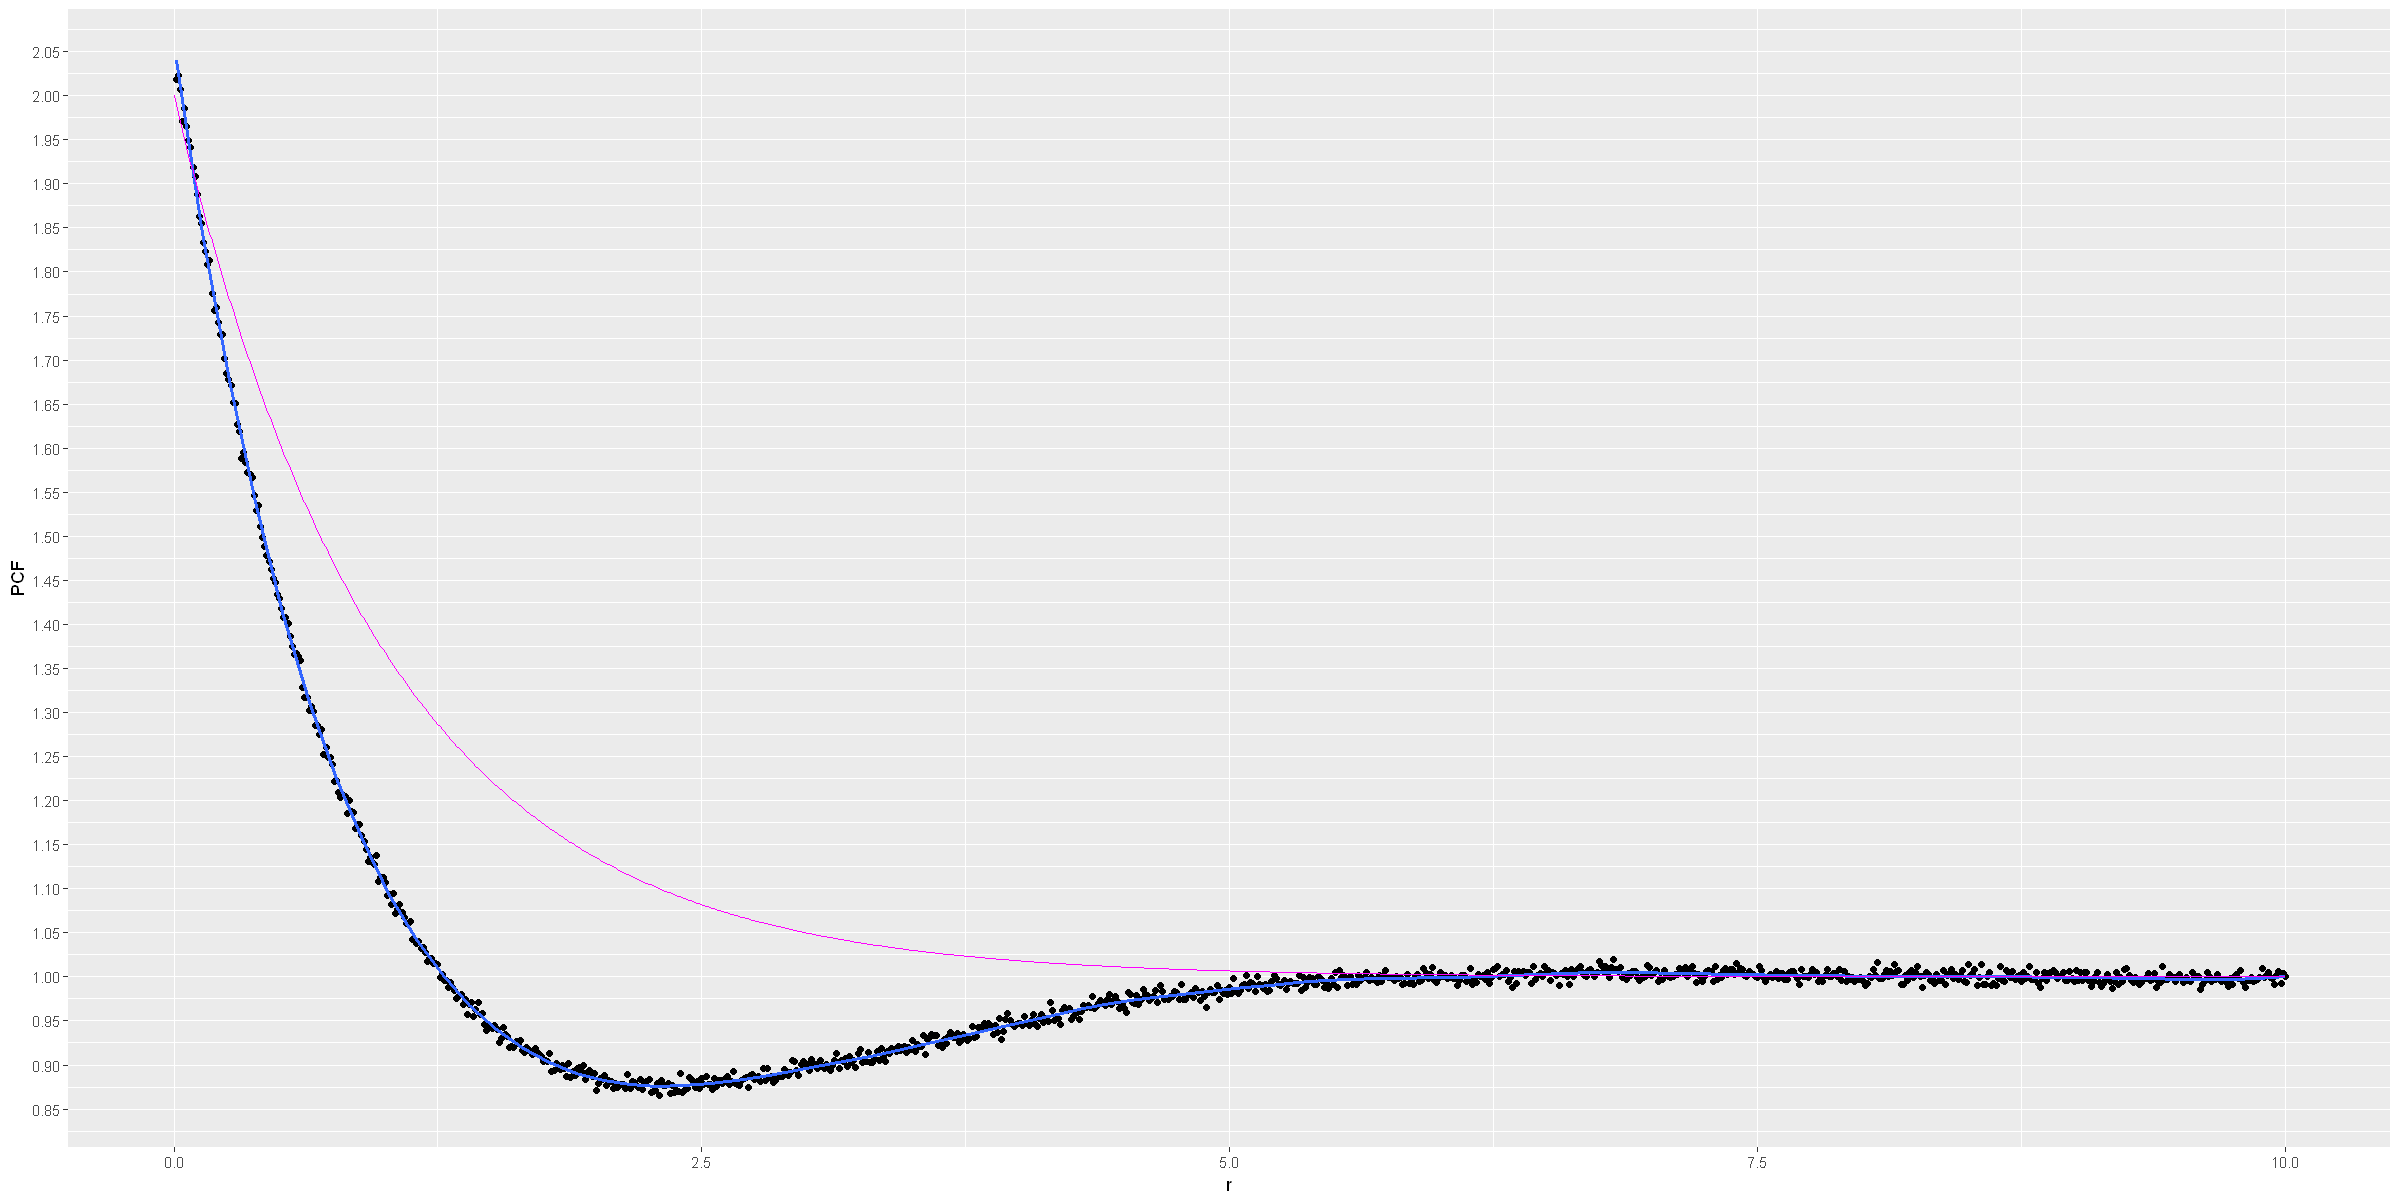

In [8]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data=data.frame(x=x_grid,y=pcf_est_av),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  geom_line(data=data.frame(x=x_grid,y=sapply(x_grid,function(x){exp(-x)+1})),aes(x=x,y=y),colour="magenta")+
  scale_y_continuous(breaks = seq(0.85, 2.1, by = 0.05))+
  labs(x="r",y="PCF")

In [10]:
mean(pop)/area_length_x

[1] 0.7939052